# Permutaion Feature Importanceによる重要な特徴量の可視化

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# データセットの取得

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris['feature_names']
target_names = iris.target_names

print("データセット内容の種類")
print(iris.keys())
print("特徴量の種類")
print(iris['feature_names'])
print("ラベルの種類")
print(target_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

データセット内容の種類
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
特徴量の種類
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
ラベルの種類
['setosa' 'versicolor' 'virginica']
X_train.shape =  (120, 4)
y_train.shape =  (120,)
X_test.shape =  (30, 4)
y_test.shape =  (30,)


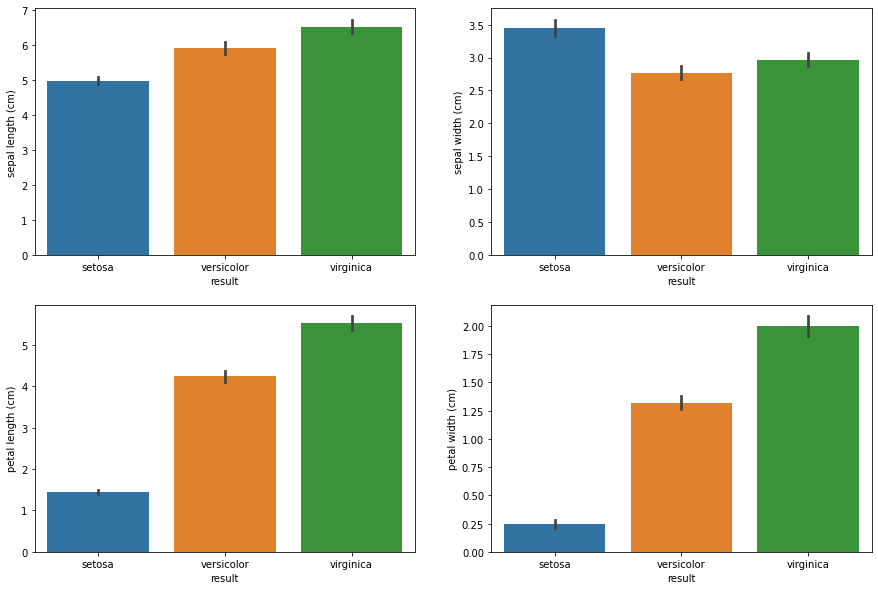

In [3]:
X_train_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)

y_label = []
for i in y_train:
    y_label.append(target_names[i])
y_train_dataframe = pd.DataFrame(y_label, columns=['result'])

train_dataframe = pd.concat([X_train_dataframe, y_train_dataframe], axis=1)

import seaborn as sns

fig = plt.figure(figsize=[15,10])
for i, f in enumerate(iris['feature_names']):
    fig.add_subplot(2, 2, i+1)
    sns.barplot(y=f, x='result', data= train_dataframe)

# モデルの学習と評価

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = sklearn.ensemble.RandomForestClassifier(n_estimators=2, max_depth = 3, random_state=2)
model.fit(X_train, y_train)

accuracy_score(y_test, model.predict(X_test))

0.9666666666666667

In [5]:
data_index = 1
y_index = y_test[data_index]
print('target name = ' + target_names[y_index])
pd.DataFrame([X_test[data_index]], columns=feature_names)

target name = setosa


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.7,3.8,1.7,0.3


# Permutaion Feature Importanceによる重要な特徴量の可視化

各特徴量の要素をランダムに並べ替え予測結果の増加減から重要な特徴量を確認する

重要な特徴量であれば予測結果に大きく影響を及ぼし、重要でない特徴量であれば影響が少ない

In [6]:
from sklearn.inspection import permutation_importance

pfi = permutation_importance(estimator=model,
                             X=X_test,
                             y=y_test,
                             scoring='neg_root_mean_squared_error',
                             n_repeats=5,
                             n_jobs=-1,
                             random_state=42)

pfi_df = pd.DataFrame(data={'feature_names': feature_names, 'importance': pfi['importances_mean']})

<BarContainer object of 4 artists>

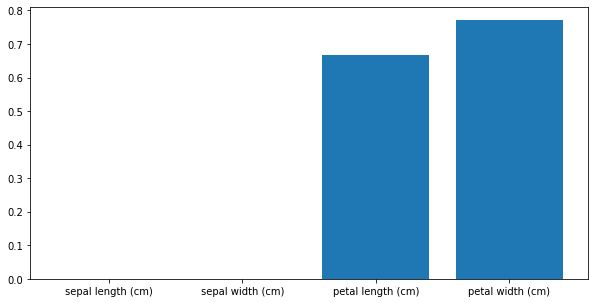

In [7]:
fig = plt.figure(figsize=[10,5])
plt.bar(pfi_df['feature_names'], pfi_df['importance'])

# Permutation Feature Importance手法の実装

下記リポジトリを参考

https://github.com/ghmagazine/ml_interpret_book/blob/main/ch3/ch3_Permutation_Feature_Importance.ipynb

In [8]:
from dataclasses import dataclass
from typing import Any
from __future__ import annotations
from sklearn.metrics import mean_squared_error


@dataclass
class PermutationFeatureImportance:
    """Permutation Feature Importance (PFI)
     
    Args:
        estimator: 全特徴量を用いた学習済みモデル
        X: 特徴量
        y: 目的変数
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    y: np.ndarray
    var_names: list[str]
        
    def __post_init__(self) -> None:
        # シャッフルなしの場合の予測精度
        # mean_squared_error()はsquared=TrueならMSE、squared=FalseならRMSE
        self.baseline = mean_squared_error(
            self.y, self.estimator.predict(self.X), squared=False
        )

    def _permutation_metrics(self, idx_to_permute: int) -> float:
        """ある特徴量の値をシャッフルしたときの予測精度を求める

        Args:
            idx_to_permute: シャッフルする特徴量のインデックス
        """

        # シャッフルする際に、元の特徴量が上書きされないよう用にコピーしておく
        X_permuted = self.X.copy()

        # 特徴量の値をシャッフルして予測
        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(self, n_shuffle: int = 10) -> None:
        """PFIを求める

        Args:
            n_shuffle: シャッフルの回数。多いほど値が安定する。デフォルトは10回
        """

        J = self.X.shape[1]  # 特徴量の数

        # J個の特徴量に対してPFIを求めたい
        # R回シャッフルを繰り返して平均をとることで値を安定させている
        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in range(J)
        ]

        # データフレームとしてまとめる
        # シャッフルでどのくらい予測精度が落ちるかは、
        # 差(difference)と比率(ratio)の2種類を用意する
        df_feature_importance = pd.DataFrame(
            data={
                "var_name": self.var_names,
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline,
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )
        
    def plot(self, importance_type: str = "difference") -> None:
        """PFIを可視化

        Args:
            importance_type: PFIを差(difference)と比率(ratio)のどちらで計算するか
        """

        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance["var_name"],
            self.feature_importance[importance_type],
            label=f"baseline: {self.baseline:.2f}",
        )
        ax.set(xlabel=importance_type, ylabel=None)
        ax.invert_yaxis() # 重要度が高い順に並び替える
        ax.legend(loc="lower right")
        fig.suptitle(f"Permutation Importance({importance_type})")
        
        fig.show()

C:\Users\naolu\AppData\Local\Temp/ipykernel_14212/577845289.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


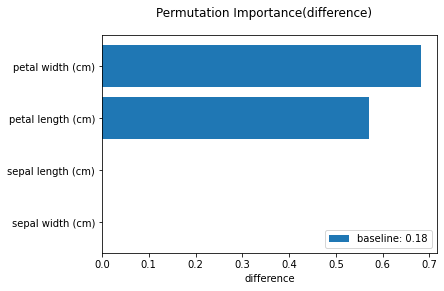

In [10]:
pfi = PermutationFeatureImportance(model, X_test, y_test, feature_names)
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")